## Скачиваем датасет из репозитория.
 В датасете хранится таблица с двуми столбцами тэг и его класс

In [1]:
!wget https://raw.githubusercontent.com/avtararin/clastering_tags/main/datasamples/tags-21-06.csv

--2024-08-15 10:36:51--  https://raw.githubusercontent.com/avtararin/clastering_tags/main/datasamples/tags-21-06.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63928 (62K) [text/plain]
Saving to: ‘tags-21-06.csv’

tags-21-06.csv      100%[===================>]  62.43K  --.-KB/s    in 0.01s   

2024-08-15 10:36:51 (4.63 MB/s) - ‘tags-21-06.csv’ saved [63928/63928]



In [2]:
!pip install sentence-transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distiluse-base-multilingual-cased-v2')


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

## Импорт необходимых библиотек

In [4]:
!pip install transformers
!pip install pyyaml==5.4.1

import numpy as np
import pandas as pd
import torch
import os
import json
import csv

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [5]:
df = pd.read_csv("tags-21-06.csv", sep=',', quoting=csv.QUOTE_MINIMAL, on_bad_lines='skip')

In [6]:
from sklearn.preprocessing import LabelEncoder

# Преобразование tag_group в числовой формат
label_encoder = LabelEncoder()
df['tag_group_encoded'] = label_encoder.fit_transform(df['tag_group'])

# Проверка, как были закодированы группы
print(df[['tag_group', 'tag_group_encoded']].drop_duplicates().sort_values('tag_group_encoded'))


                           tag_group  tag_group_encoded
500                       Автомобили                  0
600                      Архитектура                  1
650                       Астрология                  2
300                           Бизнес                  3
350                        Видеоигры                  4
100                               ИТ                  5
150                             Кино                  6
0                          Кулинария                  7
200                       Литература                  8
250                           Музыка                  9
450                      Образование                 10
400                       Психология                 11
950                      Путешествия                 12
550                        Рукоделие                 13
50                             Спорт                 14
750                            медиа                 15
850                          питомцы            

## Предобработка текста

In [7]:
!pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 39.9 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=951d76a8f6e9b164c7b411a95f5a105e6347397824d79f9fd833a237694a9d1d
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import download as nltk_download
from nltk.corpus import stopwords
import pymorphy2
nltk_download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
!wget https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt
with open ("stop_ru.txt", "r") as stop_ru:
    rus_stops = [word.strip() for word in stop_ru.readlines()]
punctuation = '!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~—»«...–'
filter = rus_stops + list (punctuation)

--2024-08-15 10:40:02--  https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5823 (5.7K) [text/plain]
Saving to: ‘stop_ru.txt’

stop_ru.txt         100%[===================>]   5.69K  --.-KB/s    in 0s      

2024-08-15 10:40:02 (53.5 MB/s) - ‘stop_ru.txt’ saved [5823/5823]



In [10]:
from pymorphy2 import MorphAnalyzer
parser = MorphAnalyzer()

In [11]:
# Инициализация морфологического анализатора
morph = pymorphy2.MorphAnalyzer()

# Загрузка стоп-слов
stop_words = set(stopwords.words('russian'))

def preprocess(input_text):
    """
    Функция для предобработки текста. Слова приводятся к нижнему регистру,
    стоп-слова удаляются, глаголы удаляются, далее слова лемматизируются.
    :param input_text: Входной текст для очистки и лемматизации
    :return: Очищенный и лемматизированный текст
    """
    # Приведение текста к нижнему регистру
    text = input_text.lower()
    # Токенизация текста
    tokenized_text = word_tokenize(text)
    # Удаление стоп-слов
    clean_text = [word for word in tokenized_text if word not in stop_words]
    # Лемматизация и удаление глаголов
    lemmatized_text = []
    for word in clean_text:
        parsed_word = morph.parse(word)[0]
        if 'VERB' not in parsed_word.tag:
            lemmatized_text.append(parsed_word.normal_form)

    return ' '.join(lemmatized_text)

# Пример использования
input_text = "Я пишу проект, который должен определить к какому кластеру относится тэг."
processed_text = preprocess(input_text)
print(processed_text)

проект , который должный определить какой кластер тэг .


In [12]:
df["text_processed"] = df["tag"].map(preprocess)

Далее воспользуемся вспомогательными классами Dataset и Dataloader из torch.utils. Создадим класс CustomDataset на основе импортированного класса Dataset. Для корректной работы переопределим в нем методы __len__ и __getitem__.

Добавим метод tokenize, внутри которого к тексту будет применяться инициализированный ранее tokenizer. Формат выходных данных будет torch.tensor. Поставим максимальную длину токенизированного текста на 10 токенов.

In [13]:
class CustomDataset(Dataset):

    def __init__(self, X):
        self.text = X

    def tokenize(self, text):
        return tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=10)

    def __len__(self):
        return self.text.shape[0]

    def __getitem__(self, index):
        output = self.text[index]
        output = self.tokenize(output)
        return {k: v.reshape(-1) for k, v in output.items()}

corpus = df['text_processed']
eval_ds = CustomDataset(corpus)
eval_dataloader = DataLoader(eval_ds, batch_size=10)

## Модель без mean_pooling

In [14]:
# Предположим, что у вас есть столбец 'tag' в DataFrame
tags = df['text_processed'].tolist()

# Получение эмбеддингов для всех тегов
embeddings = model.encode(tags)


In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Применение KMeans к эмбеддингам
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)

# Оценка качества кластеризации
kmeans_score = silhouette_score(embeddings, kmeans_labels)
print("K-Means Silhouette Score:", kmeans_score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Silhouette Score: 0.104872584


In [16]:
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px

# Снижение размерности для визуализации
pca = PCA(n_components=2, random_state=42)
emb_2d = pd.DataFrame(pca.fit_transform(embeddings), columns=['x1', 'x2'])
emb_2d['label_kmeans'] = kmeans_labels

# Визуализация
fig = px.scatter(emb_2d, x='x1', y='x2', color='label_kmeans', width=800, height=600)
fig.show()


In [17]:
from sklearn.metrics import adjusted_rand_score

# Предположим, что у вас есть закодированные истинные метки (tag_group)
ari_score = adjusted_rand_score(df['tag_group'].astype('category').cat.codes, kmeans_labels)
print("ARI Score:", ari_score)


ARI Score: 0.2000434812551229


In [18]:
from sklearn.metrics import accuracy_score

# Применяем K-Means к эмбеддингам
predicted_labels = kmeans.labels_

# Подсчитываем accuracy, сравнивая предсказанные метки и истинные
accuracy = accuracy_score(df['tag_group_encoded'], predicted_labels)
print(f"Accuracy: {accuracy}")


Accuracy: 0.044


In [19]:
compare = pd.DataFrame({'tag_group' : df['tag_group'].values, 'pred_labels' : predicted_labels, 'true_labels' : df['tag_group_encoded'].values})

In [20]:
compare

,tag_group,pred_labels,true_labels
0,Кулинария,3,7
1,Кулинария,15,7
2,Кулинария,3,7
3,Кулинария,3,7
4,Кулинария,5,7
...,...,...,...
995,Путешествия,6,12
996,Путешествия,18,12
997,Путешествия,5,12
998,Путешествия,3,12


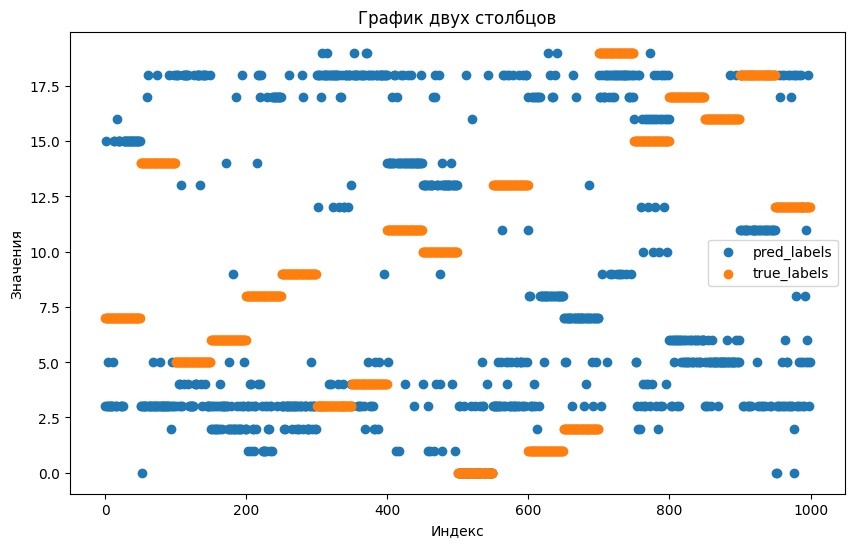

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(compare.index, compare['pred_labels'], label='pred_labels')
plt.scatter(compare.index, compare['true_labels'], label='true_labels')

plt.xlabel('Индекс')
plt.ylabel('Значения')
plt.title('График двух столбцов')
plt.legend()

plt.show()

In [22]:
import torch.onnx
# Предполагается, что model - это ваша модель, а dummy_input - это пример входных данных.
dummy_input = df.tag.values
torch.onnx.export(model, dummy_input, "model.onnx")

RuntimeError: Only tuples, lists and Variables are supported as JIT inputs/outputs. Dictionaries and strings are also accepted, but their usage is not recommended. Here, received an input of unsupported type: numpy.ndarray